In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

%matplotlib inline

### Datasets

In [2]:
from datasets import list_datasets

all_datasets = list_datasets()

In [3]:
print(f'Total datasets available: {len(all_datasets)}')
print(f'Few datasets are: \n{all_datasets[:10]}')

Total datasets available: 10000
Few datasets are: 
['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


#### Loading a dataset

In [4]:
from datasets import load_dataset

In [5]:
emotions = load_dataset("SetFit/emotion")

Using custom data configuration SetFit--emotion-89147fdf376d67e2


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/SetFit___json/SetFit--emotion-89147fdf376d67e2/0.0.0/da492aad5680612e4028e7f6ddc04b1dfcec4b64db470ed7cc5f2bb265b9b6b5. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 16000
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2000
    })
})

- Like a python dictionary. We have 3 key-value pairs corresponding to train, test and validation.
- The values are of dataset class

In [7]:
train = emotions['train']
train

Dataset({
    features: ['text', 'label', 'label_text'],
    num_rows: 16000
})

In [8]:
train.shape

(16000, 3)

In [9]:
train[0]

{'text': 'i didnt feel humiliated', 'label': 0, 'label_text': 'sadness'}

In [10]:
train[:3]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong'],
 'label': [0, 0, 3],
 'label_text': ['sadness', 'sadness', 'anger']}

In [11]:
# We can select rows of spcific columns as well
train['text'][:3]

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong']

- We can convert our datasets to pandas dataframe format for analysis and visualization.
- This does not change the underlying data format (apache arrow table).
- We can easily convert back to datasets format if required.

In [12]:
emotions.set_format(type='pandas')
df = emotions['train'][:]

In [13]:
df.head(3)

,text,label,label_text
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger


Text(0.5, 0, 'Number of rows')

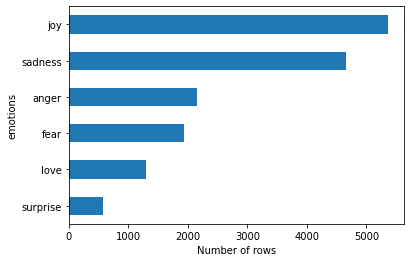

In [14]:
# plot class distribution
df.label_text.value_counts(ascending=True).plot(kind='barh')
plt.ylabel('emotions')
plt.xlabel('Number of rows')

Text(0.5, 0.98, '')

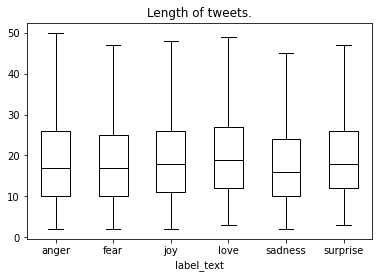

In [15]:
# Distribution of tweet lengths
df['text_len'] = df['text'].str.split().apply(len)
df.boxplot(column='text_len', by='label_text', grid=False, showfliers=False, color='black')
plt.title('Length of tweets.')
plt.suptitle("")

In [16]:
# reset format
emotions.reset_format()

### Tokenization

In [17]:
from transformers import AutoTokenizer

In [18]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [19]:
sample_text = "(4 Cans) Del Monte Whole Kernel Canned Corn, 15.25 oz"
tokenize_text = tokenizer(sample_text)
tokenize_text

{'input_ids': [101, 1006, 1018, 18484, 1007, 3972, 10125, 2878, 16293, 27141, 9781, 1010, 2321, 1012, 2423, 11472, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [20]:
tokens = tokenizer.convert_ids_to_tokens(tokenize_text['input_ids'])
print(tokens)

['[CLS]', '(', '4', 'cans', ')', 'del', 'monte', 'whole', 'kernel', 'canned', 'corn', ',', '15', '.', '25', 'oz', '[SEP]']


In [21]:
tokenizer.convert_tokens_to_string(tokens)

'[CLS] ( 4 cans ) del monte whole kernel canned corn, 15. 25 oz [SEP]'

In [22]:
# Attributes of tokenizer
print(tokenizer.vocab_size)
print(tokenizer.model_max_length)
print(tokenizer.model_input_names)

30522
512
['input_ids', 'attention_mask']


##### Tokenizing a batch using map()

In [23]:
def tokenize_batch(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

In [24]:
emotions['train'][:3]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong'],
 'label': [0, 0, 3],
 'label_text': ['sadness', 'sadness', 'anger']}

In [25]:
tokenize_batch(emotions['train'][:3])

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102], [101, 10047, 9775, 1037, 3371, 2000, 2695, 1045, 2514, 20505, 3308, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}

In [26]:
# Tokenize all
emotions_encoded = emotions.map(tokenize_batch, batched=True, batch_size=None)

Parameter 'function'=<function tokenize_batch at 0x7f0fae05d4c0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [27]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    test: Dataset({
        features: ['text', 'label', 'label_text', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

## Training a Classifier

### 1. Using transformers as feature extractor

In [28]:
from transformers import AutoModel
model = AutoModel.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [30]:
# Sample Run
text = "this is a test"
inputs = tokenizer(text, return_tensors='pt')

In [31]:
inputs

{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

In [32]:
# place inputs in the same device as model
inputs = {k:v.to(device) for k,v in inputs.items()}

In [33]:
with torch.no_grad():
    outputs = model(**inputs)
outputs

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)

In [34]:
outputs['last_hidden_state'].size()

torch.Size([1, 6, 768])

- 1 --> number of inputs sequences. (batch_size)
- 6 --> length of input sequence (will be padded) i.e. number of tokens (n_tokens)
- 768 --> output embedding corresponding to each token (hidden_dim)

**For classification task, we use the embedding corresponding to [CLS].**

In [35]:
def extract_hidden_state(batch):
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    return {'hidden_state':last_hidden_state[:,0].cpu().numpy()}

In [36]:
# encoded emotions to pytorch tensors
emotions_encoded.set_format('torch', columns=['input_ids','attention_mask','label'])

In [37]:
emotions_hidden = emotions_encoded.map(extract_hidden_state, batched=True)

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

#### Feature Matrix

In [38]:
X_train = emotions_hidden['train']['hidden_state']
Y_train = emotions_hidden['train']['label']
X_val = emotions_hidden['validation']['hidden_state']
Y_val = emotions_hidden['validation']['label']

print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)

torch.Size([16000, 768]) torch.Size([16000])
torch.Size([2000, 768]) torch.Size([2000])


### Visualizing the data

In [39]:
!pip install umap-learn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 40.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 55.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 24.4 MB/s eta 0:00:0000:0100:01
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82813 sha256=1ba09a70b16cbb75c38891757e42fec58eb08114cb8cc1c422dd3648a31a5fcf
  Stored in directory: /root/.cache/pip/wheels/f4/3e/1c/596d0a463d17475af648688443fa4846fef624d13

In [40]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

In [41]:
# Scale features to [0, 1] range
X_scaled = MinMaxScaler().fit_transform(X_train)

# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric='cosine').fit(X_scaled)

In [42]:
data = pd.DataFrame(mapper.embedding_, columns=['X','Y'])
data['label'] = Y_train

In [43]:
data.head(3)

,X,Y,label
0,4.444637,7.158825,0
1,-2.864568,6.337363,0
2,5.522604,3.643743,3


In [44]:
label = emotions['train']['label']
label_nm = emotions['train']['label_text']
label_df = pd.DataFrame({'label':label, 'name':label_nm})
label_df.drop_duplicates(inplace=True)
label_df.sort_values('label', inplace=True)

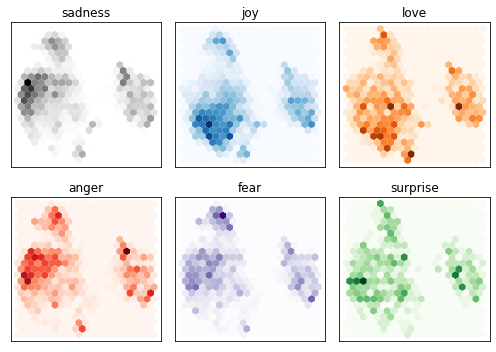

In [45]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = label_df['name']

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = data.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

### Logistic Regression

In [46]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=3000)
lr.fit(X_train, Y_train)

LogisticRegression(max_iter=3000)

In [47]:
lr.score(X_val, Y_val)

0.633

In [48]:
pred = lr.predict(X_val)

In [49]:
np.mean(pred==Y_val.numpy())

0.633

#### Dummy classifier

In [50]:
from sklearn.dummy import DummyClassifier

In [51]:
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train, Y_train)
dummy_clf.score(X_val, Y_val)

0.352

- This is an imbalanced multiclass dataset.
- Logistic regression does much better than a dummy classifier.

#### Confusion Matrix

In [52]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

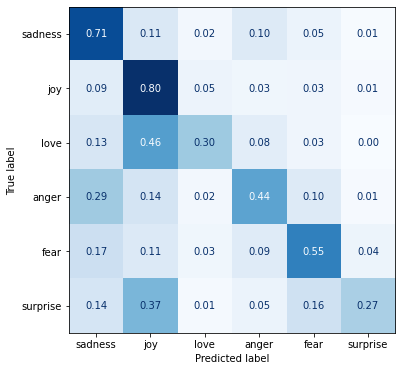

In [53]:
cm = confusion_matrix(Y_val, pred, normalize="true")
fig, ax = plt.subplots(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', ax=ax, values_format=".2f", colorbar=False)

## 2. Finetuning Transformers

In [54]:
from transformers import AutoModelForSequenceClassification

In [55]:
# Model Body
model

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(i

In [56]:
num_labels = 6
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels)
model = model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

In [57]:
# Model with sequence classification head
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [58]:
# Defining a metric
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return {'accuracy':accuracy, 'f1':f1}

In [59]:
from transformers import Trainer, TrainingArguments

In [60]:
batch_size = 64
logging_steps = len(emotions_encoded['train']) // batch_size

In [61]:
model_name = f"{model_ckpt}-finetuned-emotion" 
traininig_args = TrainingArguments(output_dir=model_name,
                                   num_train_epochs=2,
                                   learning_rate=2e-5,
                                   per_device_train_batch_size=batch_size,
                                   per_device_eval_batch_size=batch_size,
                                   weight_decay=0.01,
                                   evaluation_strategy='epoch',
                                   disable_tqdm=False,
                                   logging_steps=logging_steps,
                                   log_level='error')

In [62]:
trainer = Trainer(model=model,
                  args=traininig_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded['train'],
                  eval_dataset=emotions_encoded['validation'],
                  tokenizer=tokenizer)

In [63]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.800800,0.304319,0.906500,0.904218
2,0.240400,0.218375,0.925500,0.925509


TrainOutput(global_step=500, training_loss=0.520614128112793, metrics={'train_runtime': 225.8718, 'train_samples_per_second': 141.673, 'train_steps_per_second': 2.214, 'total_flos': 720342861696000.0, 'train_loss': 0.520614128112793, 'epoch': 2.0})

In [64]:
pred_output = trainer.predict(emotions_encoded['validation'])
pred_output.metrics

{'test_loss': 0.21837469935417175,
 'test_accuracy': 0.9255,
 'test_f1': 0.9255087638485221,
 'test_runtime': 4.8468,
 'test_samples_per_second': 412.645,
 'test_steps_per_second': 6.602}

In [65]:
pred_output.predictions.argmax(-1)

array([0, 0, 2, ..., 1, 1, 1])

In [66]:
y_pred = np.argmax(pred_output.predictions, axis=1)
y_pred

array([0, 0, 2, ..., 1, 1, 1])

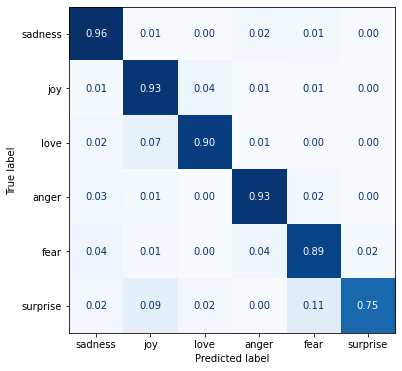

In [67]:
cm = confusion_matrix(pred_output.label_ids, y_pred, normalize="true")
fig, ax = plt.subplots(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', ax=ax, values_format=".2f", colorbar=False)

### Error Analysis

In [86]:
def forwardpass_with_label(batch):
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = F.cross_entropy(output.logits, batch['label'].to(device), reduction="none")
        return {"loss":loss.cpu().numpy(), "prediction_label":pred_label.cpu().numpy()}
        

In [89]:
# Compute loss values
emotions_encoded['validation'] = emotions_encoded['validation'].map(forwardpass_with_label, batched=True, batch_size=16)

  0%|          | 0/125 [00:00<?, ?ba/s]

In [94]:
emotions_encoded.set_format('pandas')
cols = ['text','label','label_text','prediction_label','loss']
df = emotions_encoded['validation'][:][cols]

In [109]:
df['pred_text'] = df.prediction_label.apply(lambda x: labels.tolist()[x])

In [111]:
pd.set_option('display.max_colwidth',None)
df.sort_values('loss', ascending=False).head(10)

,text,label,label_text,prediction_label,loss,pred_text
1274,i am going to several holiday parties and i can t wait to feel super awkward i am going to several holiday parties and i can t wait to feel super awkward a href http badplaydate,1,joy,0,5.643903,sadness
1500,i guess we would naturally feel a sense of loneliness even the people who said unkind things to you might be missed,3,anger,0,5.613814,sadness
765,i feel super awkward and out of place right now,1,joy,0,5.366532,sadness
882,i feel badly about reneging on my commitment to bring donuts to the faithful at holy family catholic church in columbus ohio,2,love,0,5.344917,sadness
465,i would eventually go in to these stores but i had to work up a lot of courage and i would still feel super uncomfortable once inside which we all know is not normal for me,1,joy,4,5.336517,fear
1801,i feel that he was being overshadowed by the supporting characters,2,love,0,5.251874,sadness
1509,i guess this is a memoir so it feels like that should be fine too except i dont know something about such a deep amount of self absorption made me feel uncomfortable,1,joy,4,4.966860,fear
1963,i called myself pro life and voted for perry without knowing this information i would feel betrayed but moreover i would feel that i had betrayed god by supporting a man who mandated a barely year old vaccine for little girls putting them in danger to financially support people close to him,1,joy,0,4.945270,sadness
1950,i as representative of everything thats wrong with corporate america and feel that sending him to washington is a ludicrous idea,5,surprise,0,4.944265,sadness
1870,i guess i feel betrayed because i admired him so much and for someone to do this to his wife and kids just goes beyond the pale,1,joy,0,4.893503,sadness


In [112]:
df.sort_values('loss').head(10)

,text,label,label_text,prediction_label,loss,pred_text
1502,i feel ungrateful for stupid shit like,0,sadness,0,0.012285,sadness
69,i have no extra money im worried all of the time and i feel so beyond pathetic,0,sadness,0,0.012401,sadness
1965,i started feeling pathetic and ashamed,0,sadness,0,0.012446,sadness
1152,i feel pathetic because i shouldn t complain about these things when out there people are having really hard times and this is only bullshit,0,sadness,0,0.012510,sadness
34,i feel that i m so pathetic and downright dumb to let people in let them toy with my feelings and then leaving me to clean up this pile of sadness inside me,0,sadness,0,0.012606,sadness
1466,i feel so ungrateful to be wishing this pregnancy over now,0,sadness,0,0.012627,sadness
1140,i do think about certain people i feel a bit disheartened about how things have turned out between them it all seems shallow and really just plain bitchy,0,sadness,0,0.012644,sadness
1368,i started this blog with pure intentions i must confess to starting to feel a little disheartened lately by the knowledge that there doesnt seem to be anybody reading it,0,sadness,0,0.012644,sadness
133,i and feel quite ungrateful for it but i m looking forward to summer and warmth and light nights,0,sadness,0,0.012658,sadness
1303,i feel pathetic and uninspired,0,sadness,0,0.012777,sadness
